In [11]:
import numpy as np
import os
import openmc
%matplotlib inline
import matplotlib.pyplot as plt
os.system('export OPENMC_CROSS_SECTIONS="/mnt/c/Users/djamo/Desktop/OpenMC XS/endfb-viii.0-hdf5/cross_sections.xml"')

0

<IncidentNeutron: Be9>
9
{np.int64(2): <Reaction: MT=2 (n,elastic)>, np.int64(16): <Reaction: MT=16 (n,2n)>, np.int64(102): <Reaction: MT=102 (n,gamma)>, np.int64(103): <Reaction: MT=103 (n,p)>, np.int64(104): <Reaction: MT=104 (n,d)>, np.int64(105): <Reaction: MT=105 (n,t)>, np.int64(107): <Reaction: MT=107 (n,a)>, np.int64(203): <Reaction: MT=203 (n,Xp)>, np.int64(204): <Reaction: MT=204 (n,Xd)>, np.int64(205): <Reaction: MT=205 (n,Xt)>, np.int64(207): <Reaction: MT=207 (n,Xa)>, np.int64(301): <Reaction: MT=301 heating>, np.int64(444): <Reaction: MT=444 damage-energy>, np.int64(600): <Reaction: MT=600 (n,p0)>, np.int64(650): <Reaction: MT=650 (n,d0)>, np.int64(700): <Reaction: MT=700 (n,t0)>, np.int64(701): <Reaction: MT=701 (n,t1)>, np.int64(800): <Reaction: MT=800 (n,a0)>, np.int64(901): <Reaction: MT=901 heating-local>}
[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.00

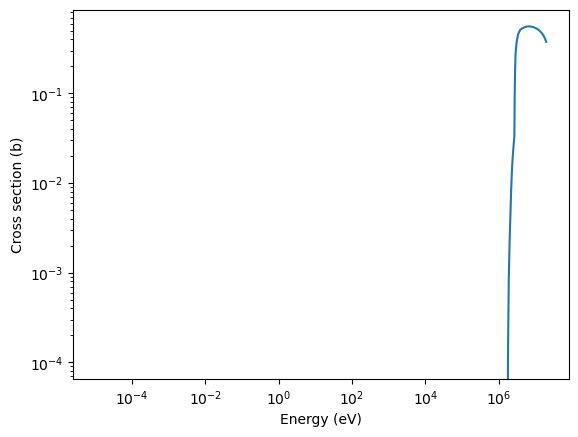

In [23]:
# Load cross section data for a specific isotope, e.g., Xe-135
xe135 = openmc.data.IncidentNeutron.from_hdf5('/mnt/c/Users/djamo/Desktop/OpenMC XS/endfb-viii.0-hdf5/neutron/Be9.h5')
print(xe135)
print(xe135.mass_number)
print(xe135.reactions)
total = xe135[16]

# # Get the cross section object
energies = xe135.energy['294K']
total_xs = total.xs['294K'](energies)
print(total_xs)
plt.loglog(energies, total_xs)
plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (b)')
plt.show()

[78.4595769 77.2654109 76.1243868 ...  0.3426796  0.338954   0.335369 ]


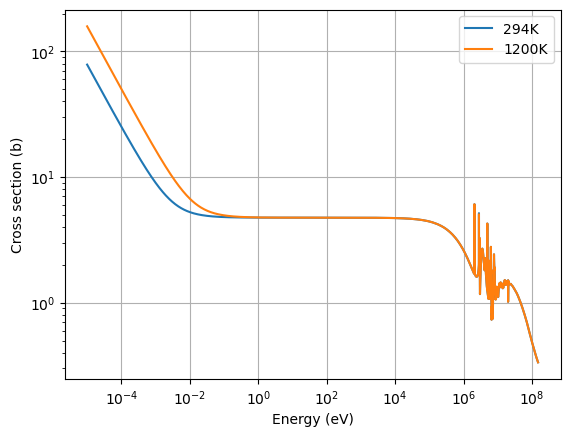

[78.4595769 77.2654109 76.1243868 ...  0.3426796  0.338954   0.335369 ]


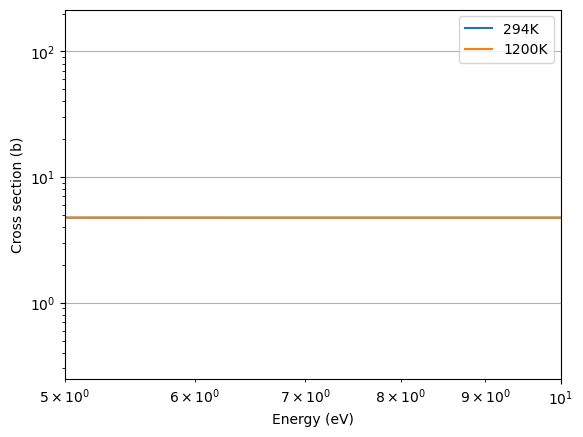

In [17]:
# Load cross section data for a specific isotope, e.g., Xe-135
u238 = openmc.data.IncidentNeutron.from_hdf5('/mnt/c/Users/djamo/Desktop/OpenMC XS/endfb-viii.0-hdf5/neutron/C12.h5')
total = u238[1]

# # Full range plot
plt.figure()
energies = u238.energy['294K']
total_xs = total.xs['294K'](energies)
print(total_xs)
plt.loglog(energies, total_xs)

energies = u238.energy['1200K']
total_xs = total.xs['1200K'](energies)
plt.loglog(energies, total_xs)

plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (b)')
plt.legend(['294K', '1200K'])
plt.grid()
plt.show()

# # Around a resonance
plt.figure()
energies = u238.energy['294K']
total_xs = total.xs['294K'](energies)
print(total_xs)
plt.loglog(energies, total_xs)

energies = u238.energy['1200K']
total_xs = total.xs['1200K'](energies)
plt.loglog(energies, total_xs)

plt.xlabel('Energy (eV)')
plt.ylabel('Cross section (b)')
plt.legend(['294K', '1200K'])
plt.xlim([5, 10])
plt.grid()
plt.show()

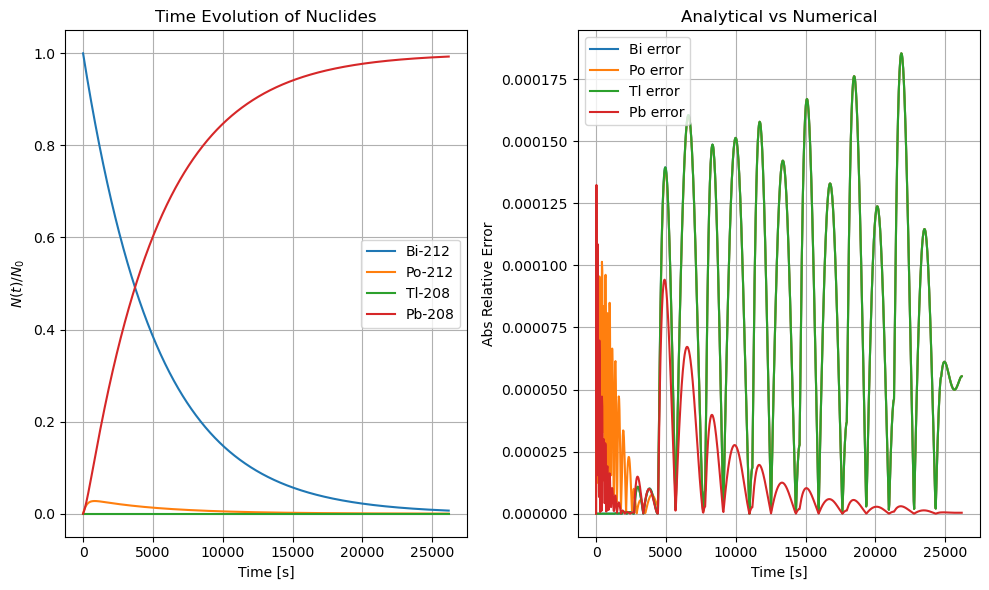

In [25]:
# Requisite imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Initial conditions
y0 = [1.0, 0.0, 0.0, 0.0]
B_r = [0.6406, 0.3594]

# Half-lives [Bi, Tl, Po] in seconds
HL = [3630, 183, 2.98E-9]     # <- if these are placeholders, replace with your course numbers
lambda_Bi = np.log(2) / HL[0]
lambda_Po = np.log(2) / HL[1]
lambda_Tl = np.log(2) / HL[2]

t_start = 0.0
t_end = 5 / lambda_Bi
t_span = (t_start, t_end)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# ODEs (now includes Pb)
def dNdt(t, y):
    N_Bi, N_Po, N_Tl, N_Pb = y
    dN_Bi = -lambda_Bi * N_Bi
    dN_Po = B_r[0] * lambda_Bi * N_Bi - lambda_Po * N_Po
    dN_Tl = B_r[1] * lambda_Bi * N_Bi - lambda_Tl * N_Tl
    dN_Pb = lambda_Po * N_Po + lambda_Tl * N_Tl
    return [dN_Bi, dN_Po, dN_Tl, dN_Pb]

# Analytical solutions (Bi, Po, Tl, Pb)
def N_bi(t):
    return y0[0] * np.exp(-lambda_Bi * t)

def N_po(t):
    num = y0[0] * B_r[0] * lambda_Bi * (np.exp(-lambda_Bi * t) - np.exp(-lambda_Po * t))
    return num / (lambda_Po - lambda_Bi)

def N_tl(t):
    num = y0[0] * B_r[1] * lambda_Bi * (np.exp(-lambda_Bi * t) - np.exp(-lambda_Tl * t))
    return num / (lambda_Tl - lambda_Bi)

def N_pb(t):
    # Pb gets whatever has left Bi, Po, Tl 
    return y0[3] + y0[0] - N_bi(t) - N_po(t) - N_tl(t)

# Precompute analytical curves
y_bi = N_bi(t_eval)
y_po = N_po(t_eval)
y_tl = N_tl(t_eval)
y_pb = N_pb(t_eval)

# Numerical integration 
sol = solve_ivp(dNdt, t_span, y0, t_eval=t_eval, method='Radau')

t_hr = sol.t
N_Bi = sol.y[0]; N_Po = sol.y[1]; N_Tl = sol.y[2]; N_Pb = sol.y[3]

# Errors (relative absolute)
def rel_abs(num, ana):
    return np.abs((num - ana) / np.maximum(np.abs(ana), 1e-300))

er_Bi = rel_abs(N_Bi, y_bi)
er_Po = rel_abs(N_Po, y_po)
er_Tl = rel_abs(N_Tl, y_tl)
er_Pb = rel_abs(N_Pb, y_pb)

# Plot (add Pb to both subplots) 
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

axs[0].plot(t_hr, N_Bi, label='Bi-212')
axs[0].plot(t_hr, N_Po, label='Po-212')
axs[0].plot(t_hr, N_Tl, label='Tl-208')
axs[0].plot(t_hr, N_Pb, label='Pb-208')          # <-- Lead
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('$N(t)/N_0$')
axs[0].set_title('Time Evolution of Nuclides')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(t_hr, er_Bi, label='Bi error')
axs[1].plot(t_hr, er_Po, label='Po error')
axs[1].plot(t_hr, er_Tl, label='Tl error')
axs[1].plot(t_hr, er_Pb, label='Pb error')        # <-- Lead
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Abs Relative Error')
axs[1].set_title('Analytical vs Numerical')
axs[1].grid(True)
axs[1].legend()

fig.tight_layout()
plt.show()


In [4]:
from math import log10

import numpy as np
import openmc

###############################################################################
# Create materials for the problem

uo2 = openmc.Material(name='UO2 fuel at 2.4% wt enrichment')
uo2.set_density('g/cm3', 10.29769)
uo2.add_element('U', 1., enrichment=2.4)
uo2.add_element('O', 2.)

helium = openmc.Material(name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)

zircaloy = openmc.Material(name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014  , 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001  , 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')

borated_water = openmc.Material(name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')

# Collect the materials together and export to XML
materials = openmc.Materials([uo2, helium, zircaloy, borated_water])
materials.export_to_xml()

###############################################################################
# Define problem geometry

# Create cylindrical surfaces
fuel_or = openmc.ZCylinder(r=0.39218, name='Fuel OR')
clad_ir = openmc.ZCylinder(r=0.40005, name='Clad IR')
clad_or = openmc.ZCylinder(r=0.45720, name='Clad OR')

# Create a region represented as the inside of a rectangular prism
pitch = 1.25984
box = openmc.model.RectangularPrism(pitch, pitch, boundary_type='reflective')

# Create cells, mapping materials to regions
fuel = openmc.Cell(fill=uo2, region=-fuel_or)
gap = openmc.Cell(fill=helium, region=+fuel_or & -clad_ir)
clad = openmc.Cell(fill=zircaloy, region=+clad_ir & -clad_or)
water = openmc.Cell(fill=borated_water, region=+clad_or & -box)

# Create a geometry and export to XML
geometry = openmc.Geometry([fuel, gap, clad, water])
geometry.export_to_xml()

###############################################################################
# Define problem settings

# Indicate how many particles to run
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

# Create an initial uniform spatial source distribution over fissionable zones
lower_left = (-pitch/2, -pitch/2, -1)
upper_right = (pitch/2, pitch/2, 1)
uniform_dist = openmc.stats.Box(lower_left, upper_right)
settings.source = openmc.IndependentSource(
    space=uniform_dist, constraints={'fissionable': True})

# For source convergence checks, add a mesh that can be used to calculate the
# Shannon entropy
entropy_mesh = openmc.RegularMesh()
entropy_mesh.lower_left = (-fuel_or.r, -fuel_or.r)
entropy_mesh.upper_right = (fuel_or.r, fuel_or.r)
entropy_mesh.dimension = (10, 10)
settings.entropy_mesh = entropy_mesh
settings.export_to_xml()

###############################################################################
# Define tallies

# Create a mesh that will be used for tallying
mesh = openmc.RegularMesh()
mesh.dimension = (100, 100)
mesh.lower_left = (-pitch/2, -pitch/2)
mesh.upper_right = (pitch/2, pitch/2)

# Create a mesh filter that can be used in a tally
mesh_filter = openmc.MeshFilter(mesh)

# Now use the mesh filter in a tally and indicate what scores are desired
mesh_tally = openmc.Tally(name="Mesh tally")
mesh_tally.filters = [mesh_filter]
mesh_tally.scores = ['flux', 'fission', 'nu-fission']

# Let's also create a tally to get the flux energy spectrum. We start by
# creating an energy filter
e_min, e_max = 1e-5, 20.0e6
groups = 500
energies = np.logspace(log10(e_min), log10(e_max), groups + 1)
energy_filter = openmc.EnergyFilter(energies)

spectrum_tally = openmc.Tally(name="Flux spectrum")
spectrum_tally.filters = [energy_filter]
spectrum_tally.scores = ['flux']

# Instantiate a Tallies collection and export to XML
tallies = openmc.Tallies([mesh_tally, spectrum_tally])
tallies.export_to_xml()

In [2]:
import matplotlib.pyplot as plt
import openmc


# Get results from statepoint
with openmc.StatePoint('statepoint.100.h5') as sp:
    t = sp.get_tally(name="Flux spectrum")

    # Get the energies from the energy filter
    energy_filter = t.filters[0]
    energies = energy_filter.bins[:, 0]

    # Get the flux values
    mean = t.get_values(value='mean').ravel()
    uncertainty = t.get_values(value='std_dev').ravel()

# Plot flux spectrum
fix, ax = plt.subplots()
ax.loglog(energies, mean, drawstyle='steps-post')
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Flux')
ax.grid(True, which='both')
plt.show()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'statepoint.100.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [10]:
plot = openmc.Plot()
plot.filename = 'pinplot'
plot.width = (pitch, pitch)
plot.pixels = (200, 200)
plot.color_by = 'material'
plot.colors = {uo2: 'yellow', water: 'blue'}

plots = openmc.Plots([plot])
plots.export_to_xml()
!cat plots.xml

openmc.run()

<?xml version='1.0' encoding='UTF-8'?>
<plots>
  <plot basis="xy" color_by="material" filename="pinplot" id="4" type="slice">
    <pixels>200 200</pixels>
    <origin>0.0 0.0 0.0</origin>
    <width>1.25984 1.25984</width>
    <color id="5" rgb="255 255 0"/>
    <color id="8" rgb="0 0 255"/>
  </plot>
</plots>


PermissionError: [Errno 13] Permission denied: 'openmc'